In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    def __init__(self,
                  input_size: int,
                  backcast_length: int,
                  forecast_length: int,
                  hidden_units: int,
                  hidden_layers: int):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
    
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(nn.ReLU())
            input_size = hidden_units
        layers.append(nn.Linear( hidden_units, backcast_length + forecast_length))
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        y = self.model(x)
        y_1d = y.squeeze()
        backcast, forecast =torch.split(y_1d, [self.backcast_length, self.forecast_length], dim=0)
        return backcast, forecast
    
class NbeatsStack(nn.Module):
    def __init__(self, 
                 input_size: int,
                 backcast_length: int,
                 forecast_length: int,
                 hidden_units: int,
                 hidden_layers: int,
                 num_blocks: int,
                 ):
        super(NbeatsStack, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length

        self.blocks = nn.ModuleList([Block(input_size, backcast_length, forecast_length, hidden_units, hidden_layers) for _ in range(num_blocks)])
    
    def forward(self, x):
        backcasts = []
        forecasts = []
        for block in self.blocks:
            backcast, forecast = block(x)
            backcasts.append(backcast.unsqueeze(1))
            forecasts.append(forecast.unsqueeze(1))
            x = torch.cat([x.squeeze(), backcast.unsqueeze(1).squeeze()], dim=0)

            backcasts = torch.cat(backcasts, dim=1)
            forecasts = torch.cat(forecasts, dim=1)
            return backcasts, forecasts

In [2]:
import yfinance as yf
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

c:\Users\Hampus\anaconda3\Lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
input_size = 10
backcast_length = 10
forecast_length = 5
hidden_units = 128
num_blocks = 4
num_layers = 4

In [4]:
import hackathon_linc as hl


In [5]:
hl.init("9d3cf8ed-d69c-44d0-adea-188775cd6cc2")



    Welcome to the LINC Hackathon! Your token is now saved in the Console. 
    That means you don't need to carry that out when using the other functions
    as long as you don't close your console. 
    
    This function is only to be used once to authenticate your token.

    You can use the link below to view the dashboard:

    hackathon.linclund.com
    
    Happy coding!

    


In [6]:
st = hl.get_all_tickers()
type(st)

list

In [9]:
data = pd.DataFrame(hl.get_historical_data(2,st[0]))
print(data)
#print(data[1]['askMedian'])
#for x in data:
#    print(x['gmtTime'])


   askMedian   askVolume  bidMedian   bidVolume              gmtTime  \
0  73.095500  648.299993  73.071067  613.133333  2015-04-23 15:00:00   
1  73.273433  560.000002  73.249433  553.183333  2015-04-23 14:00:00   
2  73.388667  368.683333  73.360900  284.066667  2015-04-23 11:00:00   
3  73.391117  293.183333  73.367567  244.733333  2015-04-23 12:00:00   
4  73.521083  491.333332  73.494683  410.483333  2015-04-23 13:00:00   
5  73.583217  293.200000  73.553800  243.016667  2015-04-23 10:00:00   
6  73.638383  441.250003  73.604850  315.366667  2015-04-23 08:00:00   
7  73.853517  277.116667  73.821467  274.916667  2015-04-23 09:00:00   
8  73.998783  273.783333  73.940367  148.300000  2015-04-24 07:00:00   

   spreadMedian  symbol  
0      0.024517  STOCK1  
1      0.024000  STOCK1  
2      0.027775  STOCK1  
3      0.023608  STOCK1  
4      0.026375  STOCK1  
5      0.029425  STOCK1  
6      0.033525  STOCK1  
7      0.032033  STOCK1  
8      0.058400  STOCK1  


In [71]:
model = NbeatsStack(input_size,
                    backcast_length,
                    forecast_length,
                    hidden_units,
                    num_layers,
                    num_blocks)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

NbeatsStack(
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (model): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=15, bias=True)
      )
    )
  )
)


In [81]:
num_epochs = 100
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    data = hl.get_historical_data(4,st[0])
    print(len(data))
    print(data[0])
    x = []
    for i in range(10):
        x.append(data[i]['askMedian'])

    #for i in range(len(x_train)):
    #    x = torch.Tensor(x_train[i])
    #    y = torch.Tensor(y_train[i])
    #    optimizer.zero_grad()
    #    backcasts, forecasts = model(x)
    #    train_outputs.append(forecasts.squeeze().tolist()[0])
    #    loss = criterion(forecasts.squeeze(), y)
    #    loss.backward()
    #    optimizer.step()

18
{'askMedian': 73.90171666666667, 'askVolume': 207.76666666666668, 'bidMedian': 73.86916666666666, 'bidVolume': 206.51666666666668, 'gmtTime': '2015-04-24 12:00:00', 'spreadMedian': 0.0324833333333333, 'symbol': 'STOCK1'}
18
{'askMedian': 73.90171666666667, 'askVolume': 207.76666666666668, 'bidMedian': 73.86916666666666, 'bidVolume': 206.51666666666668, 'gmtTime': '2015-04-24 12:00:00', 'spreadMedian': 0.0324833333333333, 'symbol': 'STOCK1'}
18
{'askMedian': 73.90171666666667, 'askVolume': 207.76666666666668, 'bidMedian': 73.86916666666666, 'bidVolume': 206.51666666666668, 'gmtTime': '2015-04-24 12:00:00', 'spreadMedian': 0.0324833333333333, 'symbol': 'STOCK1'}
18
{'askMedian': 73.90171666666667, 'askVolume': 207.76666666666668, 'bidMedian': 73.86916666666666, 'bidVolume': 206.51666666666668, 'gmtTime': '2015-04-24 12:00:00', 'spreadMedian': 0.0324833333333333, 'symbol': 'STOCK1'}
18
{'askMedian': 73.90171666666667, 'askVolume': 207.76666666666668, 'bidMedian': 73.86916666666666, 'bi

KeyError: 0

In [86]:
x = []
dates = set()
while True:
    s = hl.get_current_price()
    time = s['data'][0]['gmtTime']
    if time not in dates:
        askmed = s['data'][0]['askMedian']
        dates.add(time)
        x.append(askmed)
    print(len(dates))
    


1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33

KeyboardInterrupt: 

In [92]:
def pre_process(dataset, backcast, forecast):
    x_l = []
    y_l = []

    for i in range(backcast, len(dataset) - forecast):
        x = []
        for b in range(backcast):
            x.append(dataset[i - backcast + b])
        x_l.append(x)

        y = []
        for f in range(forecast_length):
            y.append(dataset[i + f])
        y_l.append(y)

    return x_l,y_l
x_train ,y_train = pre_process(x,10,5)
print(x_train)
print(y_train)

[[76.26, 75.57, 75.41, 74.85, 74.21, 74.09, 74.2, 74.06, 74.12, 74.23], [75.57, 75.41, 74.85, 74.21, 74.09, 74.2, 74.06, 74.12, 74.23, 73.89], [75.41, 74.85, 74.21, 74.09, 74.2, 74.06, 74.12, 74.23, 73.89, 73.79], [74.85, 74.21, 74.09, 74.2, 74.06, 74.12, 74.23, 73.89, 73.79, 73.2], [74.21, 74.09, 74.2, 74.06, 74.12, 74.23, 73.89, 73.79, 73.2, 73.38], [74.09, 74.2, 74.06, 74.12, 74.23, 73.89, 73.79, 73.2, 73.38, 72.4], [74.2, 74.06, 74.12, 74.23, 73.89, 73.79, 73.2, 73.38, 72.4, 72.16], [74.06, 74.12, 74.23, 73.89, 73.79, 73.2, 73.38, 72.4, 72.16, 71.92], [74.12, 74.23, 73.89, 73.79, 73.2, 73.38, 72.4, 72.16, 71.92, 72.22], [74.23, 73.89, 73.79, 73.2, 73.38, 72.4, 72.16, 71.92, 72.22, 72.57], [73.89, 73.79, 73.2, 73.38, 72.4, 72.16, 71.92, 72.22, 72.57, 72.74], [73.79, 73.2, 73.38, 72.4, 72.16, 71.92, 72.22, 72.57, 72.74, 72.99], [73.2, 73.38, 72.4, 72.16, 71.92, 72.22, 72.57, 72.74, 72.99, 73.28], [73.38, 72.4, 72.16, 71.92, 72.22, 72.57, 72.74, 72.99, 73.28, 73.05], [72.4, 72.16, 71.

In [93]:
num_epochs = 1
train_outputs = []
for epoch in range(num_epochs):
    model.train()
    for i in range(len(x_train)):
        x = torch.Tensor(x_train[i])
        y = torch.Tensor(y_train[i])
        optimizer.zero_grad()
        backcasts, forecasts = model(x)
        train_outputs.append(forecasts.squeeze().tolist()[0])
        loss = criterion(forecasts.squeeze(), y)
        loss.backward()
        optimizer.step()
    print(epoch)

0


In [105]:
x = []
pred = []
dates_pred = []
actual = []
dates = set()
oldDate = None
running = False
while True:
    s = hl.get_current_price()
    time = s['data'][0]['gmtTime']
    if time not in dates and running == False:
        askmed = s['data'][0]['askMedian']
        dates.add(time)
        x.append(askmed)
        
    if len(x) >= 10:
        running = True
        if time != oldDate:
            model.eval()
            with torch.no_grad():
                bc, fc = model(torch.Tensor(x))
                y = fc.squeeze()[0]
                pred.append(y.item())
                actual.append(s['data'][0]['askMedian'])
            x.pop(0)
            x.append(s['data'][0]['askMedian'])
            print("pred", pred)
            print("actual", actual)
        oldDate = time

pred [76.073486328125]
actual [73.52]
pred [76.073486328125, 76.0123291015625]
actual [73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781]
actual [73.52, 73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781, 75.74419403076172]
actual [73.52, 73.52, 73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781, 75.74419403076172, 75.71646881103516]
actual [73.52, 73.52, 73.52, 73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781, 75.74419403076172, 75.71646881103516, 75.69763946533203]
actual [73.52, 73.52, 73.52, 73.52, 73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781, 75.74419403076172, 75.71646881103516, 75.69763946533203, 75.64517974853516]
actual [73.52, 73.52, 73.52, 73.52, 73.52, 73.52, 73.52]
pred [76.073486328125, 76.0123291015625, 75.94209289550781, 75.74419403076172, 75.71646881103516, 75.69763946533203, 75.64517974853516, 75.62053680419922]
actual [73.52, 73.52, 73.52, 73.52, 73.

KeyboardInterrupt: 

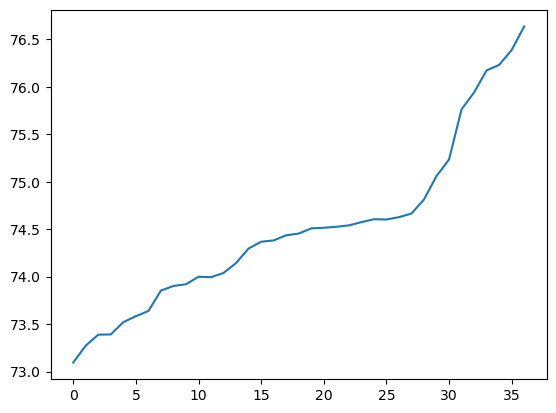

In [26]:
import matplotlib.pyplot as plt
plt.plot([i['askMedian'] for i in data])